# **Compulsory Assignment 1**
## *Machine Learning and Deep Learning (CDSCO2041C)*
*Group: MLS26_CA01*

*Student IDs: 185912, 161989, 160363 & xxx*

*Dataset: greenhouse-gas-emissions.xlsx*

---

## Question 1
### Exploratory Data Analysis (EDA)
The provided dataset contains UK territorial greenhouse gas emissions by source and activity, covering the period from 1990 onwards. Emissions are attributed to the sector that emits them directly
and include indicators related to UK territorial totals, international aviation and shipping, and Paris Agreement coverage. Perform Exploratory Data Analysis (EDA) to investigate the key factors driving changes in UK
greenhouse gas emissions over time.

1. Write a Python program to perform a covariance- and correlation-based analysis to examine
relationships between emissions, sources, and activities across years. Do not use any built-in
covariance or correlation functions. You must implement your calculations.

2. Write another Python program to visualise your findings from the previous step and briefly
explain the observed emission patterns. Hints: You may consider using histograms, boxplots,
and scatterplots.

---

### Introduction

UK territorial greenhouse gas emissions have declined substantially since 1990, but the reduction has not necessarily been uniform across the economy. Sectoral developments may reflect shared economic drivers, structural transformation, or coordinated policy effects, while breakdowns by emission source and activity provide a more operational view of what has changed in technology, fuel use, and production patterns. Treating emissions as a multivariate time series makes it possible to test whether different parts of the system move together, and whether the transition is driven by broad-based reductions or by a smaller number of dominant emission drivers. This motivates the following research question:

**To what extent do UK territorial greenhouse gas emissions exhibit common versus distinct trajectories across sectors, and which underlying sources and activities appear to drive these patterns over time?**

To address this question, we first examine trends and distributional patterns to identify the main contributors to change over time. We then quantify co-movement using covariance and correlation measures, and we also analyse year-over-year changes to reduce the risk of spurious correlations driven by shared long-run trends. Finally, we apply k-means clustering to **emission sources** based on their full emission trajectories, in order to summarise the transition into a small number of distinct pathway types and to support interpretation of which drivers have been most central to the observed decline.

In [ ]:
# Imports used in the notebook

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm
from IPython.display import Markdown, display


In [108]:
# Load dataset
file_path = "Data/greenhouse-gas-emissions.xlsx"

# Load sheets
variable_list = pd.read_excel(file_path, sheet_name="Variable_list")
uk_by_source = pd.read_excel(file_path, sheet_name="UK_by_source")
unfccc_by_source = pd.read_excel(file_path, sheet_name="UNFCCC_by_source")


In [109]:
# Initial Dataset Overview
# Inspect variable descriptions

# Clean column names
variable_list.columns = variable_list.columns.str.strip()

# Relevant columns only
variables_table = variable_list.iloc[:, :2]
variables_table.columns = ["Variable", "Description"]
variables_table

,Variable,Description
0,Included in UK territorial total,Identifies emissions included in the UK territ...
1,Included in UK UNFCCC total,Identifies emissions included in the territori...
2,Included in UK Paris Agreement total,Identifies emissions included in the territori...
3,GHG,"The greenhouse gas emitted, with different spe..."
4,GHG grouped,"The greenhouse gas emitted, with F-gases group..."
5,CRT category,Categories defined in international guidelines...
6,CRT category description,Text description for each CRT category.
7,Year,The calendar year in which the emissions occur...
8,Territory name,"The territory where the emissions occurred, ei..."
9,Territorial Emissions Statistics sector,A grouping of the TES subsectors and categories.


### Analysis of Policy-Relevant Emissions

UK Carbon Budgets and official progress assessments are based on territorial emissions, meaning emissions that occur within the UK’s geographic boundaries. To ensure that the statistical analysis is aligned with the policy framework and carbon accounting methodology, we restrict the dataset to observations included in the UK territorial total. This step ensures that subsequent covariance and correlation results reflect structurally relevant emission dynamics rather than memo items or internationally reported components that are treated separately in climate policy.

Rather than analysing hundreds of highly granular emission sources, we aggregate emissions to the top-level Territorial Emissions Statistics sectors. This aggregation improves interpretability, reduces dimensionality, and ensures that the covariance structure captures meaningful sector-level relationships rather than noise from very small individual sources. The sector-level aggregation reflects structured combinations of underlying sources and activities. Each sector is composed of multiple emission sources and fuel or activity categories, meaning that sectoral time series capture broader structural emission dynamics rather than isolated micro-level processes.

In [111]:
# EDA of emission data

# Basic shape of dataset
print("Rows, columns:", uk_by_source.shape)

# Year coverage
print("Years:", uk_by_source["Year"].min(),
      "→", uk_by_source["Year"].max(),
      "| n =", uk_by_source["Year"].nunique())

# Structural overview
print("Unique sectors:",
      uk_by_source["Territorial Emissions Statistics sector"].nunique())
print("Unique subsectors:",
      uk_by_source["Territorial Emissions Statistics subsector"].nunique())
print("Unique sources:",
      uk_by_source["Source"].nunique())
print("Unique fuel groups:",
      uk_by_source["Fuel group"].nunique())

# Missing values check
print("Missing emission values:",
      uk_by_source["Emissions (MtCO2e)"].isna().sum())

uk_by_source.describe()

Rows, columns: (78022, 15)
Years: 1990 → 2024 | n = 35
Unique sectors: 9
Unique subsectors: 28
Unique sources: 700
Unique fuel groups: 5
Missing emission values: 0


,Year,Emissions (MtCO2e)
count,78022.000000,78022.000000
mean,2007.771295,0.293069
std,9.982078,3.036902
min,1990.000000,-18.002028
25%,1999.000000,0.000124
50%,2008.000000,0.002087
75%,2016.000000,0.026358
max,2024.000000,184.014756


In [112]:
# Column name for top-level sector classification
SECTOR_COL = "Territorial Emissions Statistics sector"

# Restrict dataset to emissions included in the UK territorial total
# This aligns the analysis with UK Carbon Budget accounting principles
territorial = uk_by_source[
    uk_by_source["Included in UK territorial total"].str.lower() == "yes"
].copy()

# Aggregate emissions to sector level for each year
# This reduces dimensionality and creates annual sector-level time series
sector_year = (
    territorial
    .groupby(["Year", SECTOR_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

### Reshaping the Data to Wide Format (Years × Sectors)

To compute covariance and correlation across sectors, the dataset must be structured such that each sector constitutes a separate variable observed across a common set of time periods. In the original long format, emissions are indexed by year and sector, which is not directly suitable for multivariate statistical analysis. We therefore reshape the dataset into wide format, where rows represent years and columns represent aggregated sectors.

In this representation, each column corresponds to a sector-specific emission time series, and each row represents an observation in time. This structure allows us to compute pairwise covariance and correlation across sectors and to examine whether emission trajectories exhibit systematic co-movement over the 1990–2024 period.

In [113]:
# Reshaping the Data to Wide Format (Years × Sectors)

# Pivot to wide format
pivot_sec = (
    sector_year
    .pivot(index="Year",
           columns=SECTOR_COL,
           values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

pivot_sec.head()

Territorial Emissions Statistics sector,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Year,,,,,,,,
1990,54.988754,109.492561,124.191169,203.990902,77.192227,155.662400,10.266883,55.039201
1991,54.800121,121.292199,122.552535,200.562839,78.080868,156.665141,9.772005,56.836696
1992,54.457877,117.743777,123.850246,188.466186,79.240850,149.650442,8.962862,58.000423
1993,53.561508,121.671071,124.995984,170.963203,78.927561,143.356940,8.401128,59.475666
1994,54.320493,116.627834,125.175291,166.731982,71.448923,145.437790,7.925957,60.982346


### Covariance and Correlation Analysis

To examine whether sectoral emissions exhibit structural co-movement over time, we compute sample covariance and correlation across sector-level emission time series. Rather than relying on built-in functions, we manually implement the underlying formulas in order to ensure transparency of the statistical calculations and to demonstrate understanding of the methodological foundations discussed in Lecture 02.

For each sector, the annual emission series represents a variable observed over the period 1990–2024. The sample covariance between two sectors (x) and (y) is defined as:

$$
\text{cov}(x,y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
$$

where (\bar{x}) and (\bar{y}) denote sample means. We use (n-1) to obtain the unbiased sample estimator. Covariance measures the magnitude of joint variation: large positive values indicate that sectors tend to increase or decrease together in absolute terms, while negative values indicate opposing movements.

However, covariance is scale-dependent. Large sectors such as electricity supply or industry naturally generate higher covariance values due to their greater emission levels and variability. To obtain a scale-independent measure, we compute the sample correlation:

$$
\text{corr}(x,y) = \frac{\text{cov}(x,y)}{s_x s_y}
$$

where (s_x) and (s_y) are the sample standard deviations. Correlation ranges between −1 and 1 and captures the strength and direction of linear co-movement across sectors. High positive correlations suggest coordinated structural change, while weaker correlations may indicate sector-specific dynamics.

### Addressing Spurious Trend Effects

Sectoral emissions exhibit strong long-run downward trends over the sample period. As a result, correlations computed on levels may partly reflect shared time dependence rather than genuine structural interaction. To distinguish common trending behaviour from synchronized short-run adjustments, we therefore also analyse year-over-year (YoY) changes. By computing covariance and correlation on first differences, we assess whether sectors co-move beyond their shared long-run decline.

This distinction is important for interpretation. Strong correlations in levels may reflect broad decarbonisation across the economy, whereas correlations in YoY changes provide evidence of whether reductions occur simultaneously across sectors or follow heterogeneous transition paths.

Together, the level-based and YoY-based analyses allow us to evaluate whether emission reductions in the UK reflect coordinated structural transformation or uneven sectoral adjustment. These findings form the empirical foundation for the subsequent clustering analysis.

In [114]:
# We implement the sample mean, variance, standard deviation,
# covariance, and correlation manually (ddof = 1).

def mean(xs):
    xs = list(xs)
    return sum(xs) / len(xs)

def variance(xs, ddof=1):
    xs = list(xs)
    n = len(xs)
    if n <= ddof:
        return float("nan")
    m = mean(xs)
    return sum((x - m) ** 2 for x in xs) / (n - ddof)

def std(xs, ddof=1):
    v = variance(xs, ddof=ddof)
    return math.sqrt(v) if not math.isnan(v) else float("nan")

def covariance(xs, ys, ddof=1):
    xs, ys = list(xs), list(ys)
    n = len(xs)
    if n != len(ys) or n <= ddof:
        return float("nan")
    mx, my = mean(xs), mean(ys)
    return sum((x - mx) * (y - my) for x, y in zip(xs, ys)) / (n - ddof)

def correlation(xs, ys):
    cov = covariance(xs, ys, ddof=1)
    sx = std(xs, ddof=1)
    sy = std(ys, ddof=1)
    if sx == 0 or sy == 0 or math.isnan(cov):
        return float("nan")
    return cov / (sx * sy)

In [56]:
# Sector names (variables) for pairwise analysis
sectors = pivot_sec.columns.tolist()

# Initialize empty covariance and correlation matrices
cov_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)
corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)

# Compute pairwise covariance and correlation on emission levels
for s1 in sectors:
    for s2 in sectors:
        cov_matrix.loc[s1, s2] = covariance(
            pivot_sec[s1].values,
            pivot_sec[s2].values
        )
        corr_matrix.loc[s1, s2] = correlation(
            pivot_sec[s1].values,
            pivot_sec[s2].values
        )

# Compute year-over-year (first difference) to reduce trend-driven correlation
diff_sec = pivot_sec.diff().dropna()

# Initialize correlation matrix for YoY changes
diff_corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)

# Compute pairwise correlation on YoY changes
for s1 in sectors:
    for s2 in sectors:
        diff_corr_matrix.loc[s1, s2] = correlation(
            diff_sec[s1].values,
            diff_sec[s2].values
        )

# Display rounded matrices for readability
print("Covariance matrix (levels)")
display(cov_matrix.round(2))

print("Correlation matrix (levels)")
display(corr_matrix.round(3))

print("Correlation matrix (YoY changes)")
display(diff_corr_matrix.round(3))

Covariance matrix (levels)


,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,7.29,28.16,11.57,99.48,41.04,89.26,8.15,38.83
Buildings and product uses,28.16,173.11,67.56,575.03,181.78,373.71,31.81,193.37
Domestic transport,11.57,67.56,58.91,268.73,65.55,132.82,8.32,78.62
Electricity supply,99.48,575.03,268.73,2564.24,677.64,1408.67,118.14,677.31
Fuel supply,41.04,181.78,65.55,677.64,268.90,567.09,54.18,256.58
Industry,89.26,373.71,132.82,1408.67,567.09,1231.17,117.08,538.61
LULUCF,8.15,31.81,8.32,118.14,54.18,117.08,12.10,49.70
Waste,38.83,193.37,78.62,677.31,256.58,538.61,49.70,277.05


Correlation matrix (levels)


,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,1.000,0.793,0.558,0.728,0.927,0.942,0.867,0.864
Buildings and product uses,0.793,1.000,0.669,0.863,0.843,0.810,0.695,0.883
Domestic transport,0.558,0.669,1.000,0.691,0.521,0.493,0.312,0.615
Electricity supply,0.728,0.863,0.691,1.000,0.816,0.793,0.671,0.804
Fuel supply,0.927,0.843,0.521,0.816,1.000,0.986,0.950,0.940
Industry,0.942,0.810,0.493,0.793,0.986,1.000,0.959,0.922
LULUCF,0.867,0.695,0.312,0.671,0.950,0.959,1.000,0.858
Waste,0.864,0.883,0.615,0.804,0.940,0.922,0.858,1.000


Correlation matrix (YoY changes)


,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,1.000,0.261,0.251,-0.101,-0.069,0.238,-0.185,-0.014
Buildings and product uses,0.261,1.000,0.033,0.389,0.044,0.205,-0.017,-0.049
Domestic transport,0.251,0.033,1.000,0.114,0.069,0.125,-0.094,0.180
Electricity supply,-0.101,0.389,0.114,1.000,-0.178,0.317,-0.098,-0.117
Fuel supply,-0.069,0.044,0.069,-0.178,1.000,-0.001,-0.049,0.244
Industry,0.238,0.205,0.125,0.317,-0.001,1.000,-0.043,0.055
LULUCF,-0.185,-0.017,-0.094,-0.098,-0.049,-0.043,1.000,-0.051
Waste,-0.014,-0.049,0.180,-0.117,0.244,0.055,-0.051,1.000


In [115]:
# Correlation with Year (trend strength in levels)

years = pivot_sec.index.values  # Year variable (1990–2024)

corr_with_year_levels = pd.Series({
    sector: correlation(years, pivot_sec[sector].values)
    for sector in sectors
})

corr_with_year_yoy = pd.Series({
    sector: correlation(years_diff, diff_sec[sector].values)
    for sector in sectors
})

# Sort by level correlation only
corr_with_year_levels = corr_with_year_levels.sort_values()

corr_df = pd.DataFrame({
    "corr(Year, emissions)": corr_with_year_levels,
    "corr(Year, YoY_emissions)": corr_with_year_yoy.loc[corr_with_year_levels.index]
})

print("Correlation with Year and Year over Year Trend Strength")
display(corr_df.round(3))

Correlation with Year and Year over Year Trend Strength


,"corr(Year, emissions)","corr(Year, YoY_emissions)"
Fuel supply,-0.992,-0.030
Industry,-0.984,0.064
LULUCF,-0.937,0.604
Waste,-0.932,-0.314
Agriculture,-0.927,-0.053
Electricity supply,-0.863,-0.165
Buildings and product uses,-0.856,-0.177
Domestic transport,-0.549,-0.166


### Fuel Group Trajectories

While sector-level analysis captures institutional categories, emission reductions are ultimately driven by changes in underlying energy sources. We therefore briefly examine fuel-group trajectories to assess whether sectoral co-movement reflects structural shifts in the UK energy mix. In particular, the decline of coal and other solid fuels provides an explanatory mechanism for the strong downward trend observed in electricity supply and industry. This complementary perspective supports interpretation of the covariance results by linking sectoral decarbonisation to fuel substitution dynamics.

In [116]:
# Fuel-group trajectories (complementary perspective to sector analysis)

FUEL_COL = "Fuel group"

# Aggregate territorial emissions by year and fuel group
fuel_year = (
    territorial
    .groupby(["Year", FUEL_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

# Reshape to wide format: rows = years, columns = fuel groups
pivot_fuel = (
    fuel_year
    .pivot(index="Year", columns=FUEL_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

# Fuel-group list for pairwise correlation analysis
fuel_groups = pivot_fuel.columns.tolist()

# Pairwise correlation matrix across fuel-group emission trajectories (levels)
fuel_corr = pd.DataFrame(index=fuel_groups, columns=fuel_groups, dtype=float)
for g1 in fuel_groups:
    for g2 in fuel_groups:
        fuel_corr.loc[g1, g2] = correlation(
            pivot_fuel[g1].values,
            pivot_fuel[g2].values
        )

# Correlation with Year to quantify trend strength for each fuel group
years_fuel = pivot_fuel.index.values
corr_fuel_year = pd.Series(
    {g: correlation(years_fuel, pivot_fuel[g].values) for g in fuel_groups}
)

# Display outputs with proper titles
print("Fuel-Group Emissions (First Observations)")
display(pivot_fuel.head())

print("Correlation Matrix (Fuel Groups – Emission Levels)")
display(fuel_corr.round(3))

print("Correlation with Year (Fuel Groups – Trend Strength)")
display(corr_fuel_year.sort_values().to_frame("corr(Year, fuel_group_emissions)").round(3))

Fuel-Group Emissions (First Observations)


Fuel group,Coal,Gaseous fuels,Other emissions,Other solid fuels,Petroleum
Year,,,,,
1990,221.201645,148.464106,209.842656,14.814075,196.501615
1991,223.790559,156.244617,209.894152,14.290065,196.343011
1992,209.220581,155.377805,205.279474,14.959005,195.535798
1993,179.702582,170.932214,200.649420,15.055283,195.013564
1994,167.372512,179.496265,197.686335,13.784836,190.310669


Correlation Matrix (Fuel Groups – Emission Levels)


,Coal,Gaseous fuels,Other emissions,Other solid fuels,Petroleum
Coal,1.000,0.209,0.847,0.911,0.898
Gaseous fuels,0.209,1.000,0.195,0.178,0.272
Other emissions,0.847,0.195,1.000,0.968,0.949
Other solid fuels,0.911,0.178,0.968,1.000,0.949
Petroleum,0.898,0.272,0.949,0.949,1.000


Correlation with Year (Fuel Groups – Trend Strength)


,"corr(Year, fuel_group_emissions)"
Other emissions,-0.974
Other solid fuels,-0.972
Petroleum,-0.971
Coal,-0.925
Gaseous fuels,-0.289


The fuel-group analysis provides a structural interpretation of the sector-level results. The pronounced decline in coal and other solid fuels is consistent with the substantial reduction observed in electricity supply and parts of industry. In contrast, gaseous fuels exhibit a weaker long-run decline, reflecting substitution rather than elimination. These results suggest that sectoral co-movement is largely driven by structural shifts in the UK energy mix, particularly the phase-out of coal. Fuel substitution therefore acts as a key mechanism underlying the covariance structure identified at sector level.

### Visualisation of Emission Patterns

To complement the covariance and correlation analysis, we visualise emission trajectories across sectors and fuel groups. While covariance and correlation quantify statistical co-movement, graphical inspection allows us to examine the timing, magnitude, and variability of emission changes more directly. In particular, visualisation helps assess whether the strong correlations observed in levels reflect coordinated structural transformation or merely common long-run trends. By plotting sector-level emissions over time, we evaluate whether reductions occur gradually or through discrete structural shifts. Histograms and boxplots of year-over-year changes further reveal differences in volatility and adjustment dynamics across sectors. Together, these visual tools provide a descriptive validation of the statistical findings and support interpretation of structural change in UK greenhouse gas emissions.

Table 1. Sector emissions and percent change (1990 to 2024)


,1990,2024,pct_change_1990_2024
Territorial Emissions Statistics sector,,,
Agriculture,54.99,46.52,-15.39
Buildings and product uses,109.49,81.77,-25.31
Domestic transport,124.19,110.39,-11.12
Electricity supply,203.99,37.66,-81.54
Fuel supply,77.19,28.82,-62.66
Industry,155.66,46.50,-70.13
LULUCF,10.27,0.28,-97.23
Waste,55.04,21.45,-61.04


Table 2. Trend strength by sector (correlation with year, levels vs YoY)


,corr_year_levels,corr_year_yoy
Fuel supply,-0.992,-0.030
Industry,-0.984,0.064
LULUCF,-0.937,0.604
Waste,-0.932,-0.314
Agriculture,-0.927,-0.053
Electricity supply,-0.863,-0.165
Buildings and product uses,-0.856,-0.177
Domestic transport,-0.549,-0.166


Table 3. YoY changes by sector (summary statistics, MtCO2e)


,mean,std,min,max
Territorial Emissions Statistics sector,,,,
Agriculture,-0.25,0.93,-2.25,1.46
Buildings and product uses,-0.82,7.46,-20.21,13.45
Domestic transport,-0.41,4.56,-21.68,8.63
Electricity supply,-4.89,9.98,-23.22,14.00
Fuel supply,-1.42,2.06,-7.48,3.40
Industry,-3.21,4.80,-17.76,4.23
LULUCF,-0.29,0.39,-1.00,0.63
Waste,-0.99,1.83,-4.70,1.99


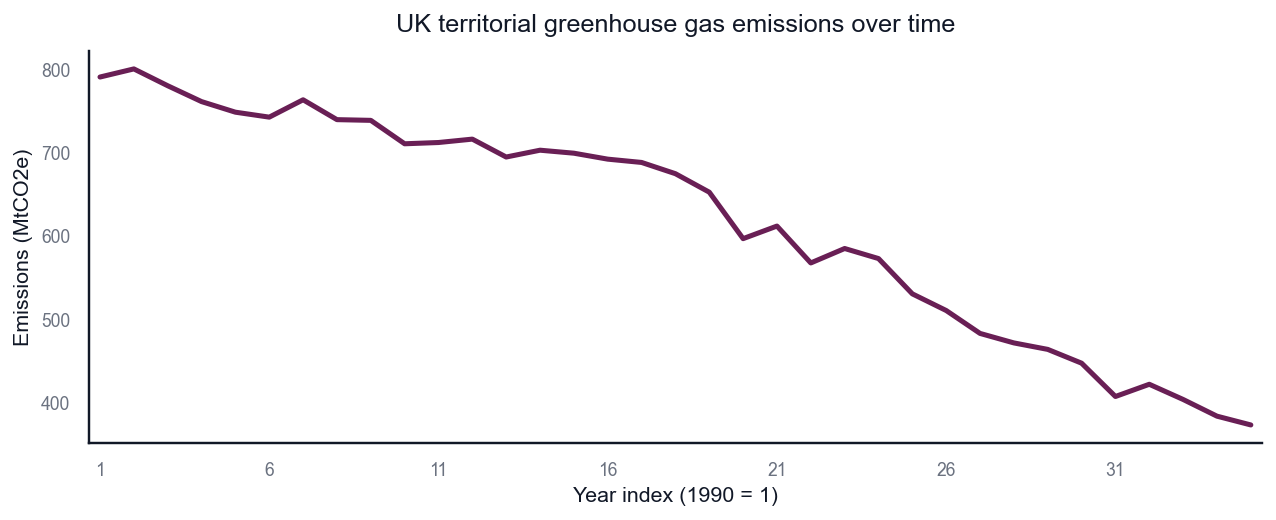

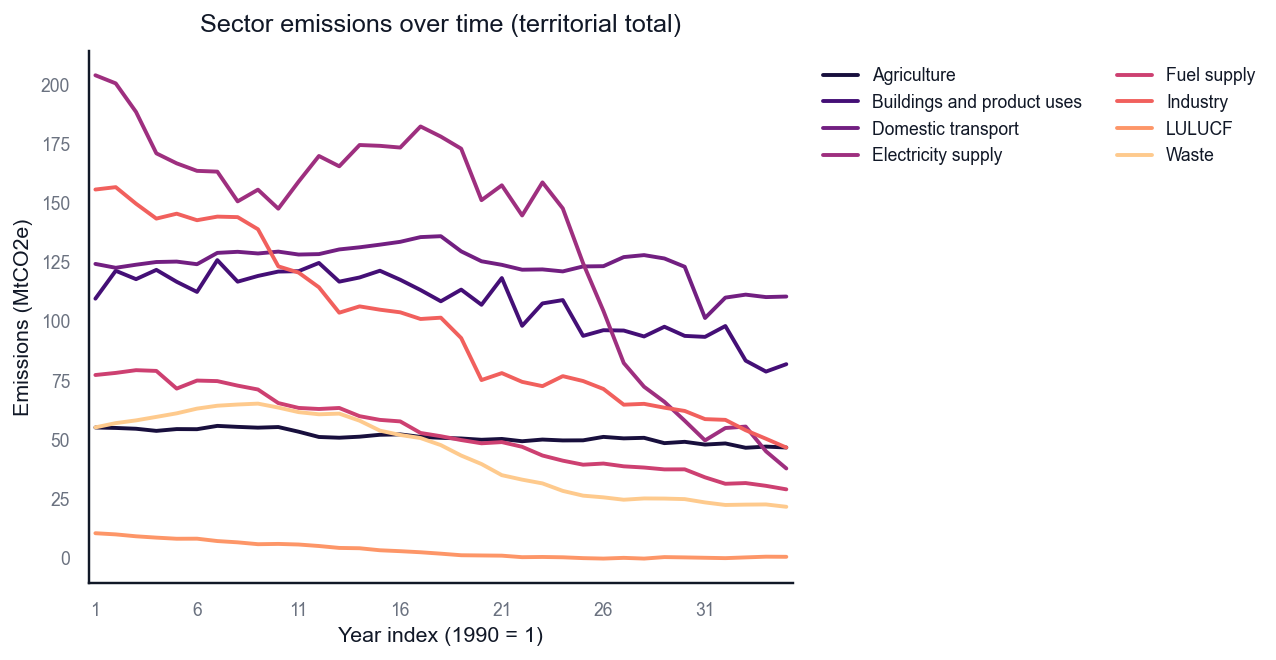

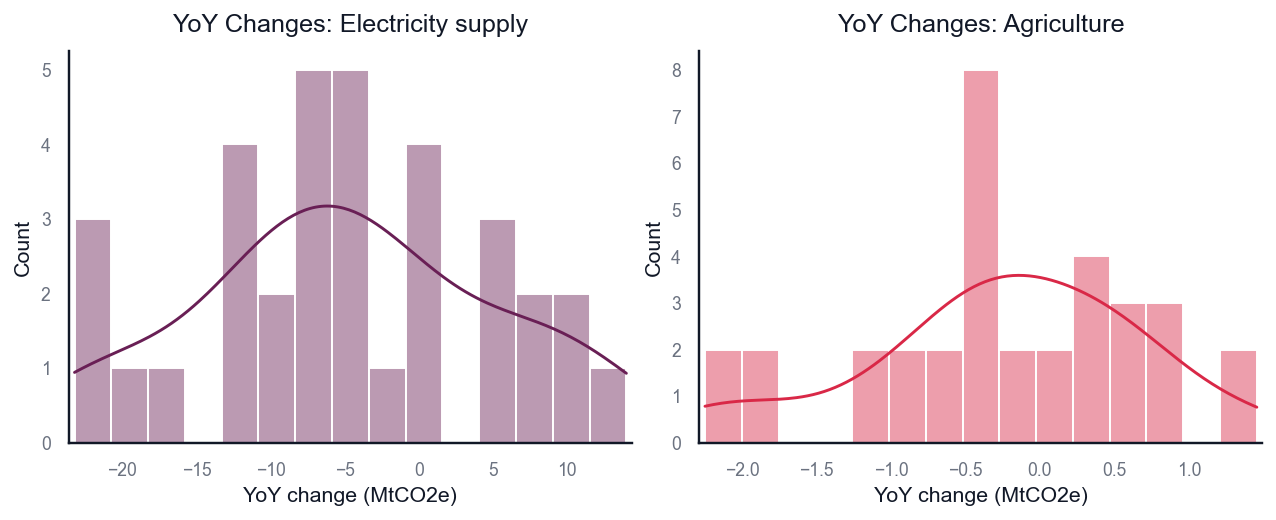

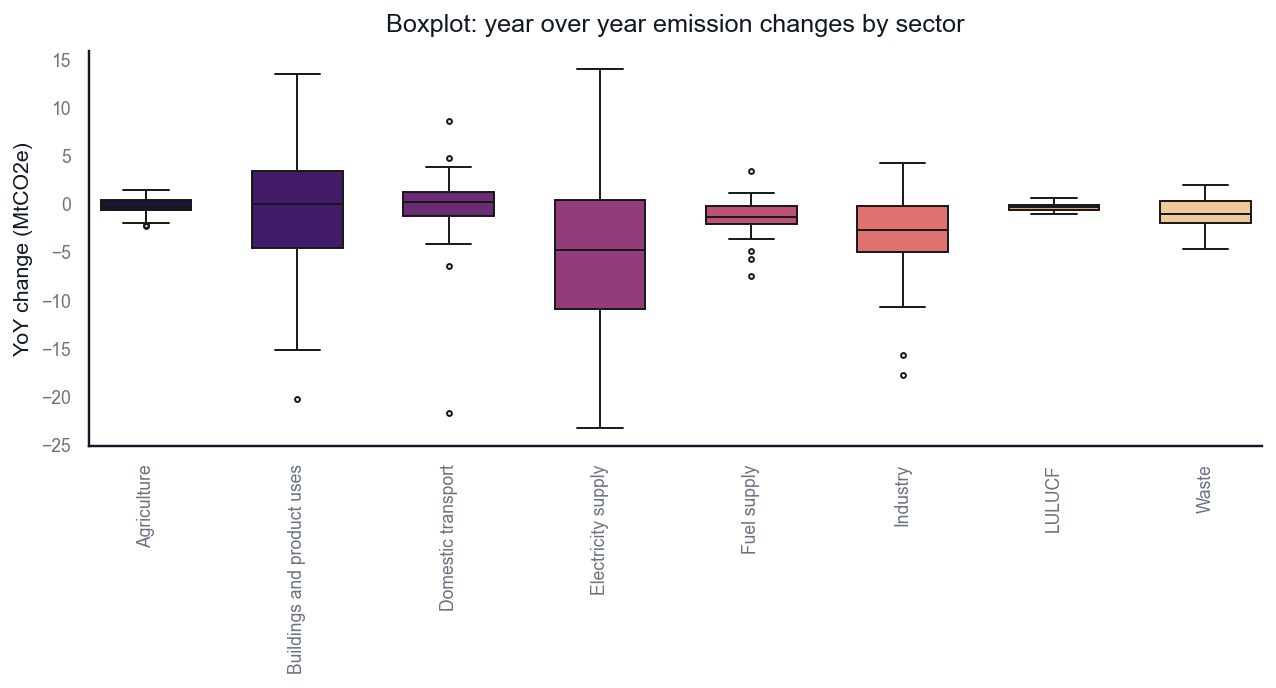

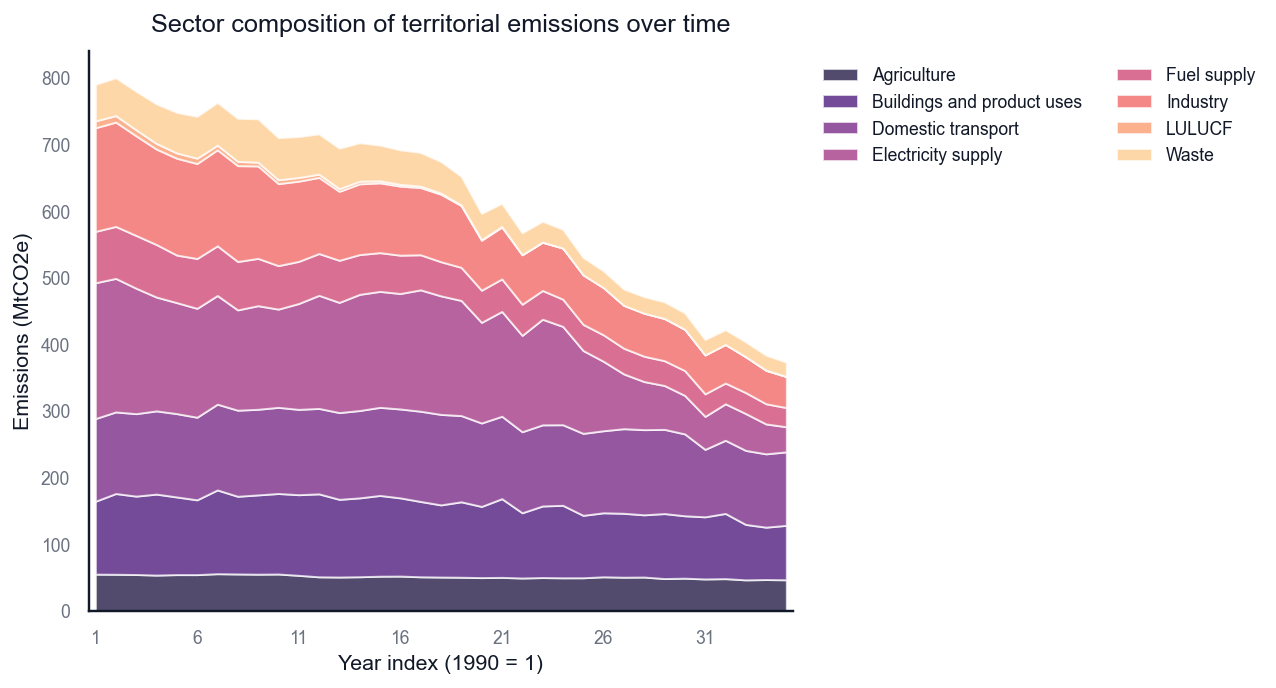

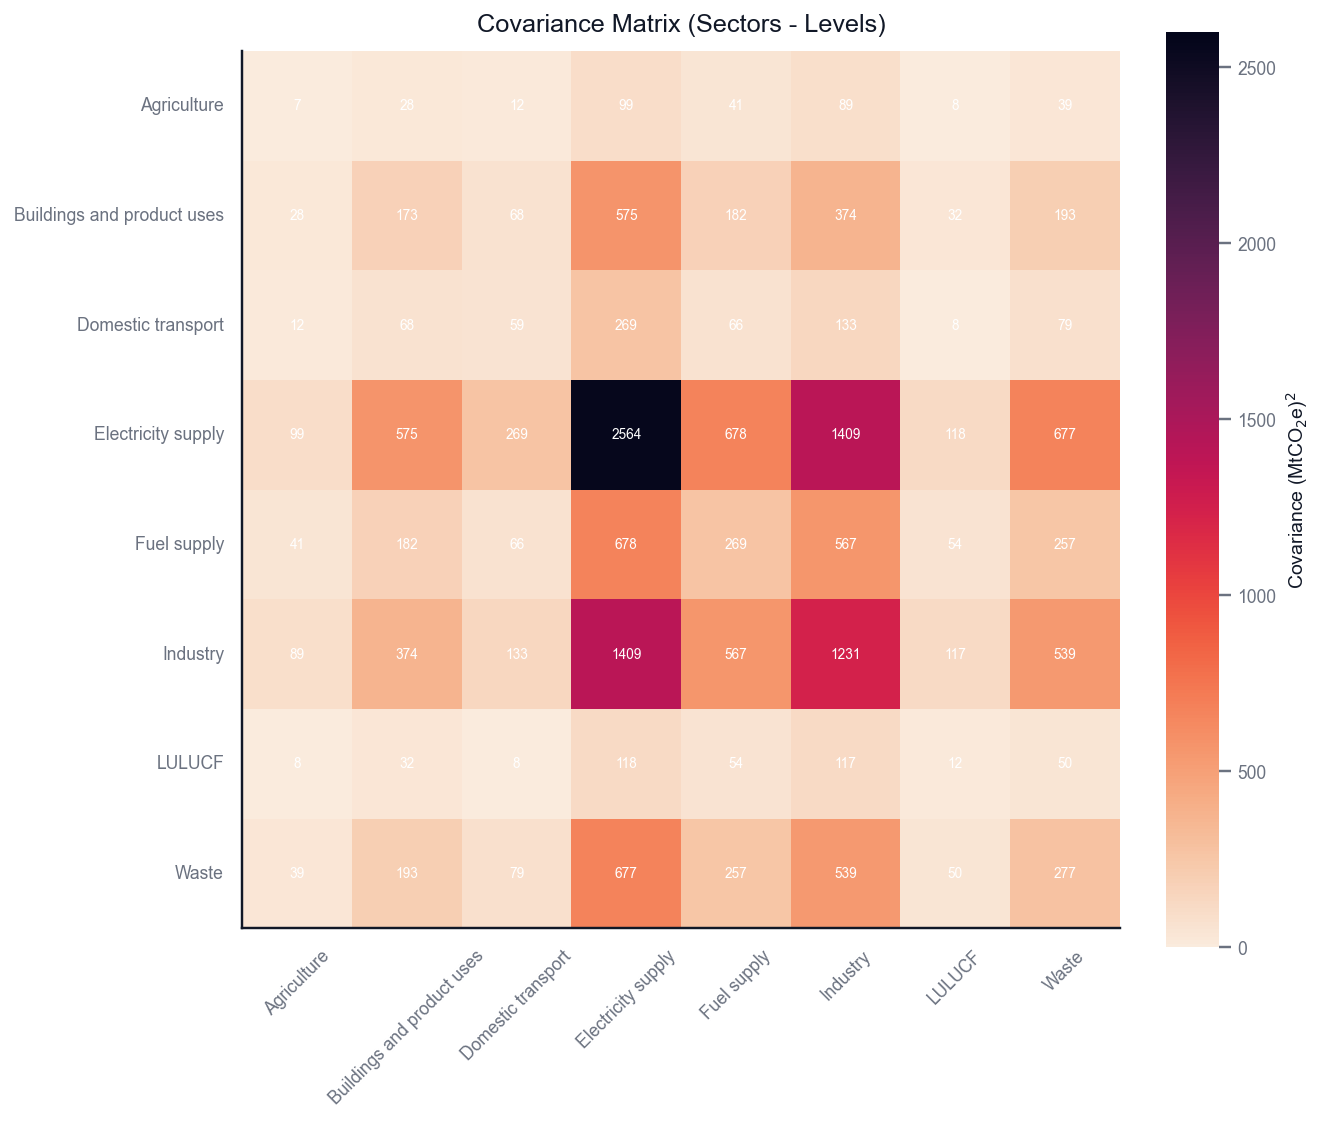

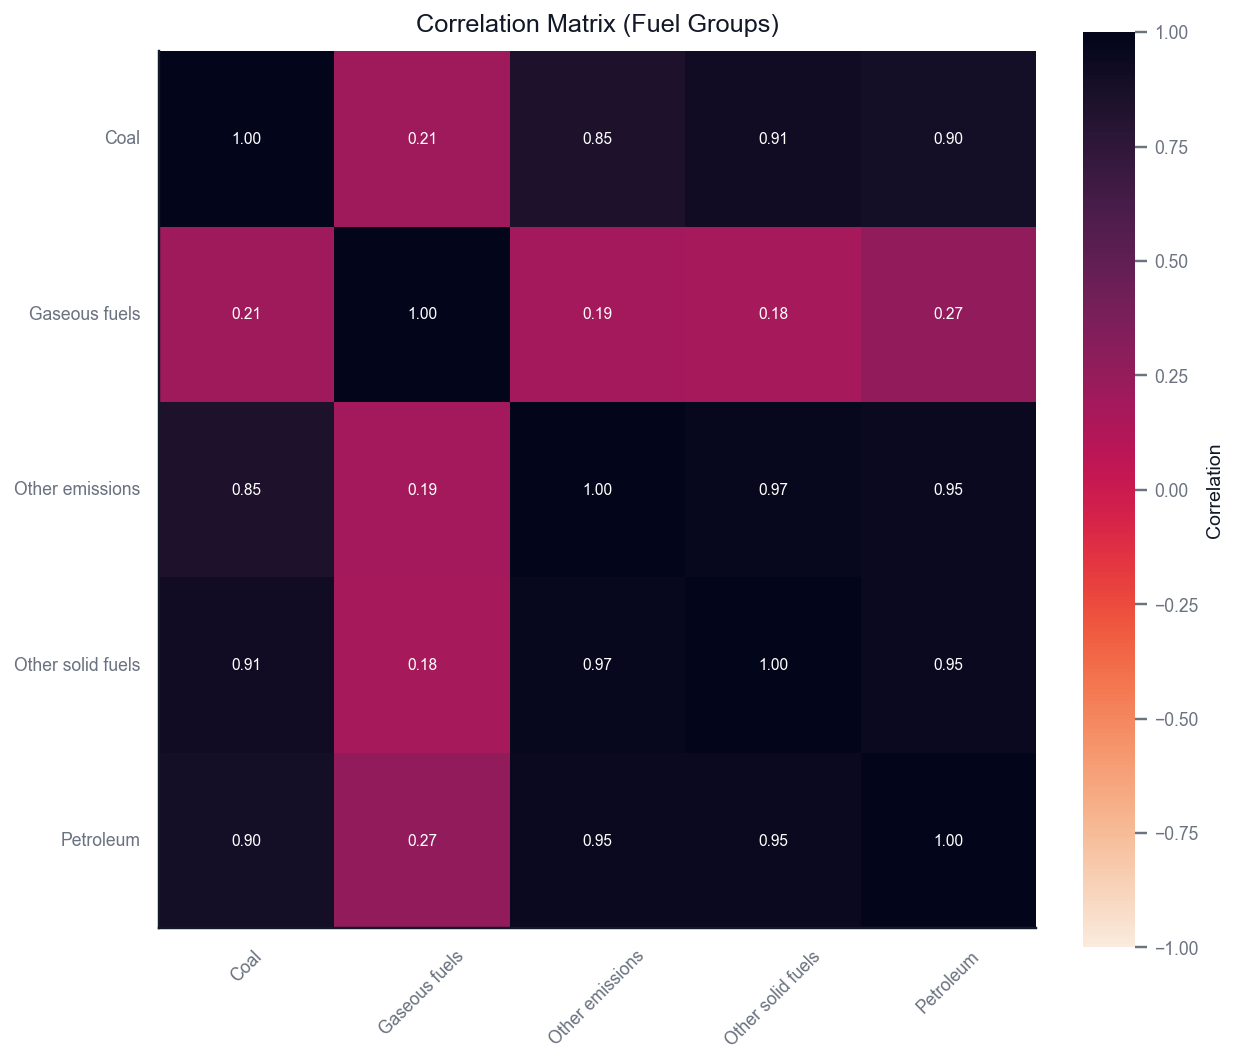

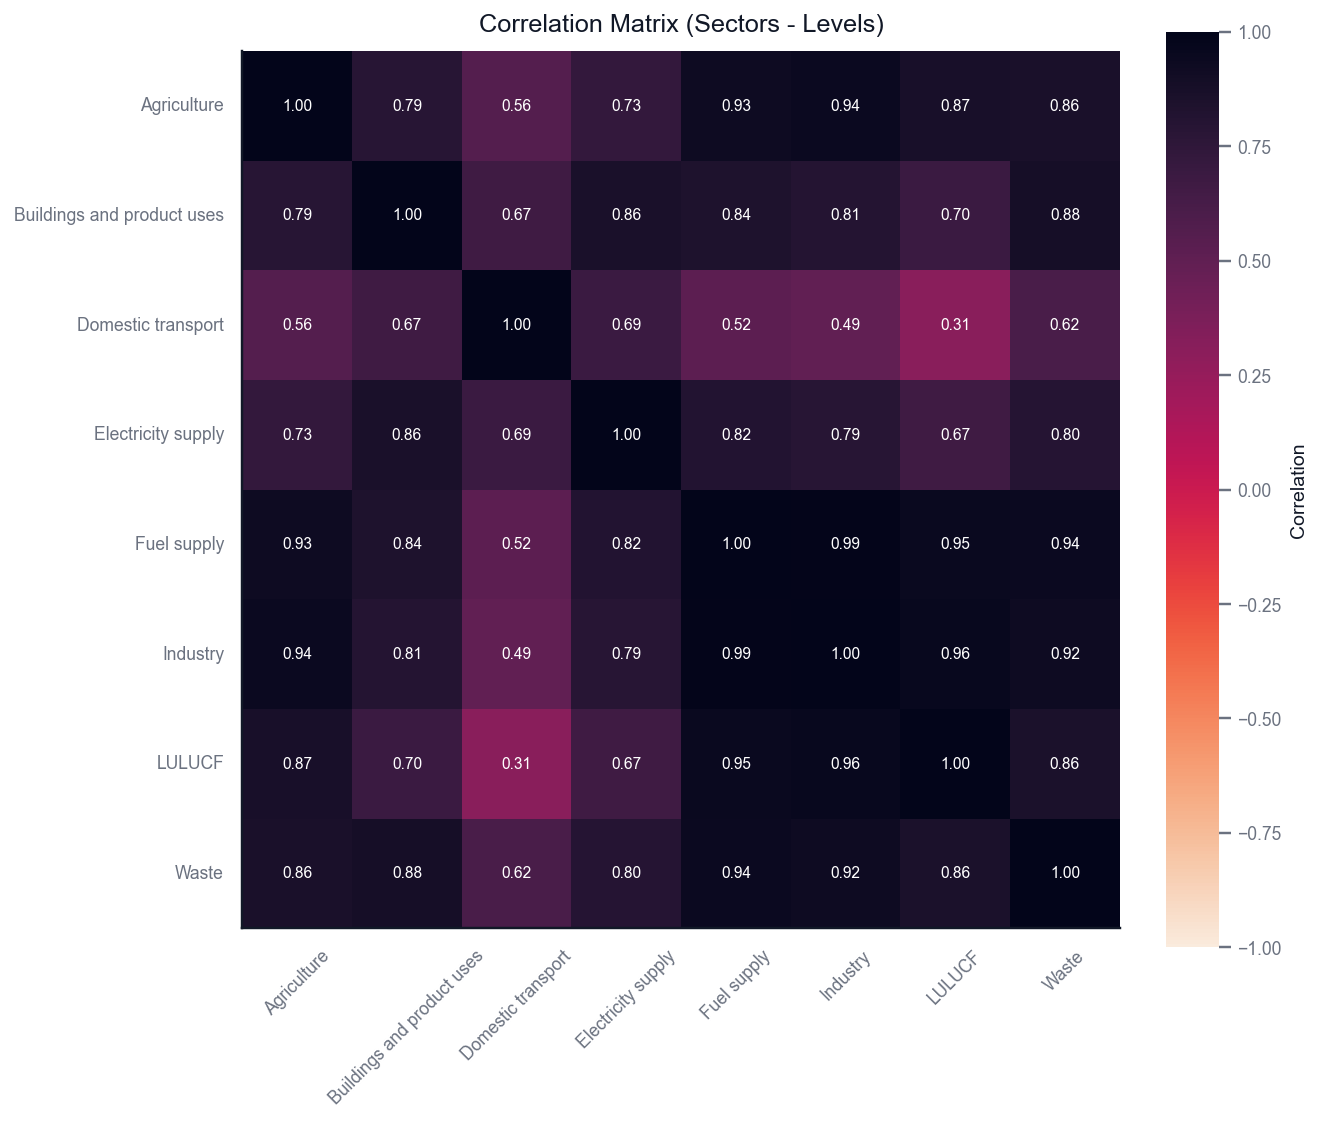

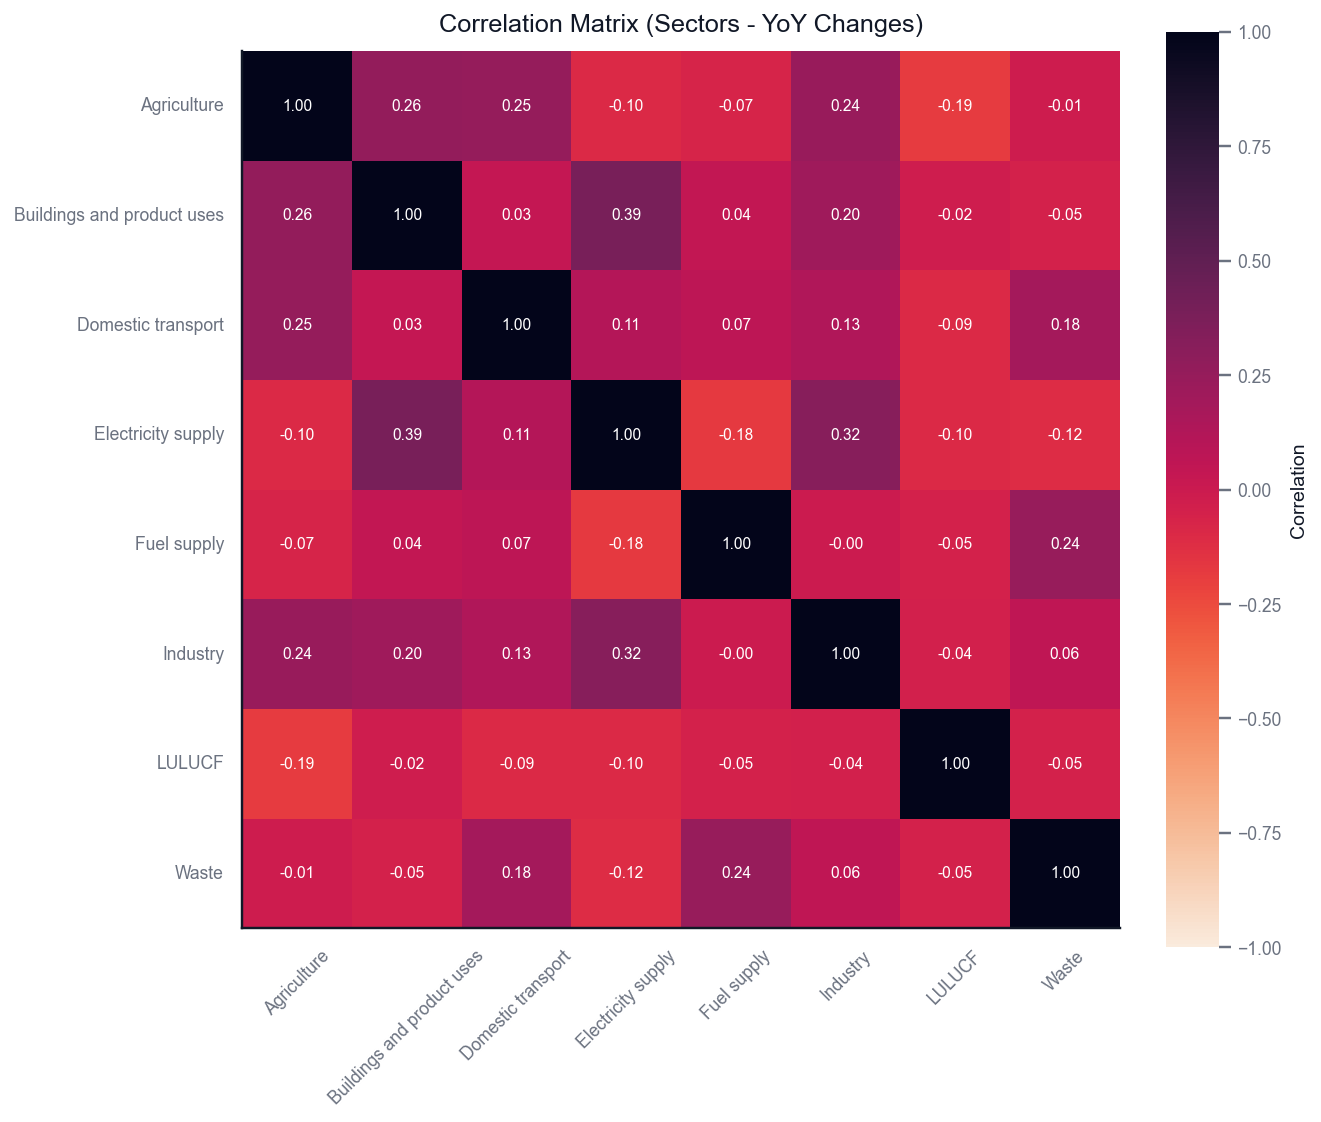

In [117]:
# Visualisation of emission patterns (sectors + YoY)

set_clean_theme()

BASE_YEAR = 1990
sector_col = SECTOR_COL if "SECTOR_COL" in globals() else "Territorial Emissions Statistics sector"
value_col = "Emissions (MtCO2e)"

# ------------------------------------------------------------
# Universal settings (one place to tweak)
# ------------------------------------------------------------
FIG_W = 9
DPI = 140

# Option A: magma (normal)
#C_MAP = sns.color_palette("magma", as_cmap=True)
#PAL_10 = sns.color_palette("magma", 10)

# Option B: rocket (normal)
# C_MAP = sns.color_palette("rocket", as_cmap=True)
# PAL_10 = sns.color_palette("rocket", 10)

# Option C: rocket reversed
C_MAP = sns.color_palette("rocket_r", as_cmap=True)
PAL_10 = sns.color_palette("rocket_r", 10)

CBAR = {"pad": 0.02, "aspect": 30}  # consistent colorbar styling

HEAT = {
    "square": True,
    "linewidths": 0.0,
    "xtick_rotation": 45,
    "ytick_rotation": 0,
    "tick_labelsize": 9,
    "annot_color": (COL_DARK if "COL_DARK" in globals() else "0.15"),
}

def fig_ax(height):
    """Standard plots: identical width and stable sizing."""
    fig, ax = plt.subplots(figsize=(FIG_W, height), dpi=DPI, constrained_layout=True)
    return fig, ax

def heatmap_fig_axes(data, *, cbar_ratio=0.06, wspace=0.10):
    """
    Heatmaps: force identical figure width and make the heatmap area fill the width.
    Keeps square cells by setting figure height from matrix shape.
    """
    nrows, ncols = data.shape
    heat_ax_w = FIG_W * (1.0 / (1.0 + cbar_ratio))  # approx width of the heatmap axis (inches)
    fig_h = heat_ax_w * (nrows / ncols)             # ensures square cells can fill width

    fig = plt.figure(figsize=(FIG_W, fig_h), dpi=DPI)
    gs = fig.add_gridspec(1, 2, width_ratios=[1.0, cbar_ratio], wspace=wspace)

    ax = fig.add_subplot(gs[0, 0])
    cax = fig.add_subplot(gs[0, 1])
    return fig, ax, cax

def heatmap_fixed(
    data, title, *, cmap=C_MAP, vmin=None, vmax=None, center=None,
    fmt=".2f", cbar_label="", annot=True, annot_size=8
):
    """Heatmap wrapper: same width, square cells, magma styling, consistent cbar column."""
    fig, ax, cax = heatmap_fig_axes(data)

    hm = sns.heatmap(
        data.astype(float),
        ax=ax,
        cbar_ax=cax,
        cmap=cmap,
        vmin=vmin, vmax=vmax, center=center,
        annot=annot, fmt=fmt,
        # annot_kws={"size": annot_size, "color": HEAT["annot_color"]},
        annot_kws={"size": annot_size, "color": "white"},  # White annotation for better contrast on dark cells
        square=HEAT["square"],
        linewidths=HEAT["linewidths"],
        cbar_kws={**CBAR, "label": cbar_label},
    )

    ax.set_title(title, pad=10)
    ax.tick_params(axis="x", rotation=HEAT["xtick_rotation"], labelsize=HEAT["tick_labelsize"])
    ax.tick_params(axis="y", rotation=HEAT["ytick_rotation"], labelsize=HEAT["tick_labelsize"])
    ax.set_xlabel("")
    ax.set_ylabel("")
    clean_ax(ax)

    cbar = hm.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label(cbar_label, fontsize=10)

    return fig, ax

# ------------------------------------------------------------
# Data prep
# ------------------------------------------------------------
territorial = territorial.copy()
territorial = territorial[territorial["Year"] >= BASE_YEAR]
if "Year_idx" not in territorial.columns:
    territorial["Year_idx"] = territorial["Year"] - BASE_YEAR + 1

if "pivot_sec" not in globals():
    pivot_sec = (
        territorial.groupby(["Year", sector_col])[value_col]
        .sum()
        .reset_index()
        .pivot(index="Year", columns=sector_col, values=value_col)
        .fillna(0.0)
        .sort_index()
    )

sectors = pivot_sec.columns.tolist()

# magma palette for sectors (keeps colouring consistent)
SECTOR_PALETTE = sns.color_palette("magma", n_colors=len(sectors))

diff_sec = pivot_sec.diff().dropna()

# Matrices (manual)
if "cov_matrix" not in globals() or "corr_matrix" not in globals():
    cov_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)
    corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)
    for s1 in sectors:
        for s2 in sectors:
            cov_matrix.loc[s1, s2] = covariance(pivot_sec[s1].values, pivot_sec[s2].values)
            corr_matrix.loc[s1, s2] = correlation(pivot_sec[s1].values, pivot_sec[s2].values)

if "diff_corr_matrix" not in globals():
    diff_corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)
    for s1 in sectors:
        for s2 in sectors:
            diff_corr_matrix.loc[s1, s2] = correlation(diff_sec[s1].values, diff_sec[s2].values)

# ------------------------------------------------------------
# Tables (report-style)
# ------------------------------------------------------------
sec_change = pd.DataFrame({"1990": pivot_sec.iloc[0], "2024": pivot_sec.iloc[-1]})
sec_change["pct_change_1990_2024"] = (sec_change["2024"] - sec_change["1990"]) / sec_change["1990"].abs() * 100
print("Table 1. Sector emissions and percent change (1990 to 2024)")
display(sec_change.round(2))

years_levels = pivot_sec.index.values
years_diff = diff_sec.index.values
trend_levels = pd.Series({s: correlation(years_levels, pivot_sec[s].values) for s in sectors})
trend_diff = pd.Series({s: correlation(years_diff, diff_sec[s].values) for s in sectors})
trend_df = pd.DataFrame({"corr_year_levels": trend_levels, "corr_year_yoy": trend_diff})
trend_df = trend_df.loc[trend_levels.sort_values().index]
print("Table 2. Trend strength by sector (correlation with year, levels vs YoY)")
display(trend_df.round(3))

diff_stats = diff_sec.agg(["mean", "std", "min", "max"]).T
print("Table 3. YoY changes by sector (summary statistics, MtCO2e)")
display(diff_stats.round(2))

# ------------------------------------------------------------
# Plots (heatmaps moved to the end)
# ------------------------------------------------------------

# Plot 1: Total territorial emissions (levels)
tot = territorial.groupby(["Year", "Year_idx"])[value_col].sum().reset_index().sort_values("Year")
fig, ax = fig_ax(3.6)
sns.lineplot(data=tot, x="Year_idx", y=value_col, ax=ax, color=PAL_10[7], linewidth=2.6)
ax.set_title("UK territorial greenhouse gas emissions over time", pad=10)
ax.set_xlabel(f"Year index ({BASE_YEAR} = 1)")
ax.set_ylabel("Emissions (MtCO2e)")
sparse_xticks(ax, tot["Year_idx"].values, step=5)
clean_ax(ax)
plt.show()

# Plot 2: Sector trajectories (levels)
sec_long = (
    territorial.groupby([sector_col, "Year", "Year_idx"])[value_col]
    .sum()
    .reset_index()
    .sort_values([sector_col, "Year"])
)
fig, ax = fig_ax(4.6)
sns.lineplot(
    data=sec_long, x="Year_idx", y=value_col, hue=sector_col,
    palette=SECTOR_PALETTE, linewidth=2.0, ax=ax
)
ax.set_title("Sector emissions over time (territorial total)", pad=10)
ax.set_xlabel(f"Year index ({BASE_YEAR} = 1)")
ax.set_ylabel("Emissions (MtCO2e)")
sparse_xticks(ax, np.sort(sec_long["Year_idx"].unique()), step=5)
clean_ax(ax)
ax.legend(frameon=False, ncol=2, bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9, title=None)
plt.show()

# Plot 3: Histograms of YoY changes (two representative sectors)
fig, axes = plt.subplots(1, 2, figsize=(FIG_W, 3.6), dpi=DPI, constrained_layout=True)

sns.histplot(
    diff_sec["Electricity supply"],
    bins=15, kde=True,
    ax=axes[0],
    alpha=0.45,
    color=PAL_10[7],
    edgecolor=None
)
axes[0].set_title("YoY Changes: Electricity supply", pad=10)
axes[0].set_xlabel("YoY change (MtCO2e)")
axes[0].set_ylabel("Count")
clean_ax(axes[0])

sns.histplot(
    diff_sec["Agriculture"],
    bins=15, kde=True,
    ax=axes[1],
    alpha=0.45,
    color=PAL_10[4],
    edgecolor=None
)
axes[1].set_title("YoY Changes: Agriculture", pad=10)
axes[1].set_xlabel("YoY change (MtCO2e)")
axes[1].set_ylabel("Count")
clean_ax(axes[1])

plt.show()

# Plot 4: Boxplot of YoY changes across sectors
diff_long = diff_sec.reset_index().melt(id_vars=["Year"], var_name="Sector", value_name="YoY_change")
fig, ax = fig_ax(4.8)
sns.boxplot(
    data=diff_long, x="Sector", y="YoY_change",
    order=sectors, hue="Sector", palette=SECTOR_PALETTE,
    dodge=False, width=0.6, fliersize=2.5, linewidth=1.0,
    ax=ax, legend=False
)
for artist in ax.artists:
    artist.set_alpha(0.40)
ax.set_title("Boxplot: year over year emission changes by sector", pad=10)
ax.set_xlabel("")
ax.set_ylabel("YoY change (MtCO2e)")
ax.tick_params(axis="x", rotation=90, labelsize=9)
clean_ax(ax)
plt.show()

# Plot 5: Stacked area showing sector composition (levels)
t = (pivot_sec.index.values - pivot_sec.index.min()) + 1
year0 = int(pivot_sec.index.min())

fig, ax = fig_ax(4.8)
ax.stackplot(
    t,
    np.vstack([pivot_sec[c].values for c in sectors]),
    labels=sectors,
    alpha=0.75,
    colors=[SECTOR_PALETTE[i % len(SECTOR_PALETTE)] for i in range(len(sectors))]
)
ax.set_title("Sector composition of territorial emissions over time", pad=10)
ax.set_xlabel(f"Year index ({year0} = 1)")
ax.set_ylabel("Emissions (MtCO2e)")
sparse_xticks(ax, t, step=5)
clean_ax(ax)
ax.legend(frameon=False, ncol=2, bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9, title=None)
plt.show()

# ------------------------------------------------------------
# Heatmaps LAST (all same width, square cells, magma cmap)
# ------------------------------------------------------------

# Heatmap 1: Covariance matrix (levels) with 0..2600 scale (no log, no weird ticks)
cov_display = cov_matrix.clip(lower=0)  # enforces 0..max behaviour visually
heatmap_fixed(
    cov_display,
    "Covariance Matrix (Sectors - Levels)",
    cmap=C_MAP,
    vmin=0, vmax=2600,
    fmt=".0f",
    cbar_label = r"Covariance (MtCO$_2$e)$^2$",
    annot=True,
    annot_size=7
)
plt.show()

# Heatmap 2: Correlation matrix (fuel groups) with magma
heatmap_fixed(
    fuel_corr,
    "Correlation Matrix (Fuel Groups)",
    cmap=C_MAP,
    vmin=-1, vmax=1, center=0,
    fmt=".2f",
    cbar_label="Correlation",
    annot=True,
    annot_size=8
)
plt.show()

# Heatmap 3: Correlation matrix (sectors - levels) with magma
heatmap_fixed(
    corr_matrix,
    "Correlation Matrix (Sectors - Levels)",
    cmap=C_MAP,
    vmin=-1, vmax=1, center=0,
    fmt=".2f",
    cbar_label="Correlation",
    annot=True,
    annot_size=8
)
plt.show()

# Heatmap 4: Correlation matrix (sectors - YoY changes) with magma
heatmap_fixed(
    diff_corr_matrix,
    "Correlation Matrix (Sectors - YoY Changes)",
    cmap=C_MAP,
    vmin=-1, vmax=1, center=0,
    fmt=".2f",
    cbar_label="Correlation",
    annot=True,
    annot_size=8
)
plt.show()

The combined statistical and graphical analysis suggests that UK territorial emissions exhibit strong positive co-movement across most sectors in levels, consistent with broad-based decarbonisation since 1990. However, correlations in year-over-year changes are substantially weaker, indicating that part of the co-movement in levels is driven by a shared long-run decline rather than synchronised short-run adjustments. The pronounced reduction in emissions linked to electricity generation, closely associated with the phase-out of coal-related activity, emerges as a central driver of the overall decline. Other sectors, such as industry and buildings, follow similarly downward trajectories but with differences in speed and volatility. Overall, the results indicate economy-wide structural decarbonisation, but with a heterogeneous distribution of emission reductions across the system.

Having established these patterns of co-movement and transition dynamics, we now examine whether emission sources can be grouped into structurally distinct clusters based on the full shape of their emission trajectories. Rather than focusing on pairwise relationships, clustering summarises the system into a small number of pathway types that may reflect differences in technological transition, policy exposure, or abatement difficulty.

---
# Question 2
## Cluster Analysis
Cluster analysis is used to group data points based on similarity in their attributes.
1. Choose one clustering algorithm discussed in the lectures and apply it to group emission sources
or activities based on their emission trajectories over time.

2. Clearly justify the variables used for clustering (e.g., emission levels, rate of change, fuel group).
Interpret the resulting clusters and explain what they reveal about structural changes in UK
greenhouse gas emissions.

3. Relate your clustering results to UK climate policy by identifying which clusters align with
sectorstargeted under UK Carbon Budgets and which sectors appear more resistant to emission
reductions.
---

In [119]:
# Source time series
SRC_COL = "Source"

src_year = (
    territorial
    .groupby(["Year", SRC_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

pivot_src = (
    src_year
    .pivot(index="Year", columns=SRC_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

# Transpose so rows = sources, columns = years
print("Shape:", X.shape)
X = pivot_src.T
X.head()



Shape: (684, 35)


Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Source,,,,,,,,,,,,,,,,,,,,,
Abandoned oil wells (offshore),0.000032,0.000034,0.000036,0.000038,0.000040,0.000043,0.000044,0.000046,0.000047,0.000049,...,0.000073,0.000074,0.000076,0.000077,0.000078,0.000078,0.000078,0.000079,0.000079,0.000079
Abandoned oil wells (onshore),0.000523,0.000527,0.000530,0.000531,0.000535,0.000542,0.000550,0.000561,0.000566,0.000571,...,0.000640,0.000641,0.000641,0.000642,0.000643,0.000644,0.000644,0.000644,0.000645,0.000645
Accidental fires - dwellings,0.007963,0.007936,0.007881,0.007581,0.007509,0.008328,0.008319,0.007969,0.007737,0.008469,...,0.003678,0.003740,0.003626,0.003664,0.003464,0.003308,0.003312,0.003398,0.003395,0.003117
Accidental fires - other buildings,0.018494,0.015709,0.015559,0.014458,0.014122,0.017225,0.014827,0.012875,0.011610,0.013080,...,0.003342,0.003334,0.003317,0.003125,0.002999,0.002672,0.002582,0.002839,0.002761,0.002727
Accidental fires - vehicles,0.001793,0.002070,0.002073,0.002087,0.001931,0.002012,0.002093,0.001976,0.001954,0.002302,...,0.000802,0.000841,0.000806,0.000805,0.000747,0.000678,0.000724,0.000769,0.000736,0.000770


After reshaping the data, each row represents one emission **source** and each column represents a **year** (1990 to 2024), so the matrix has shape *(number of sources, number of years)* and provides the emission trajectories that will be used as input for clustering.

Shape (top sources x years): (50, 35)


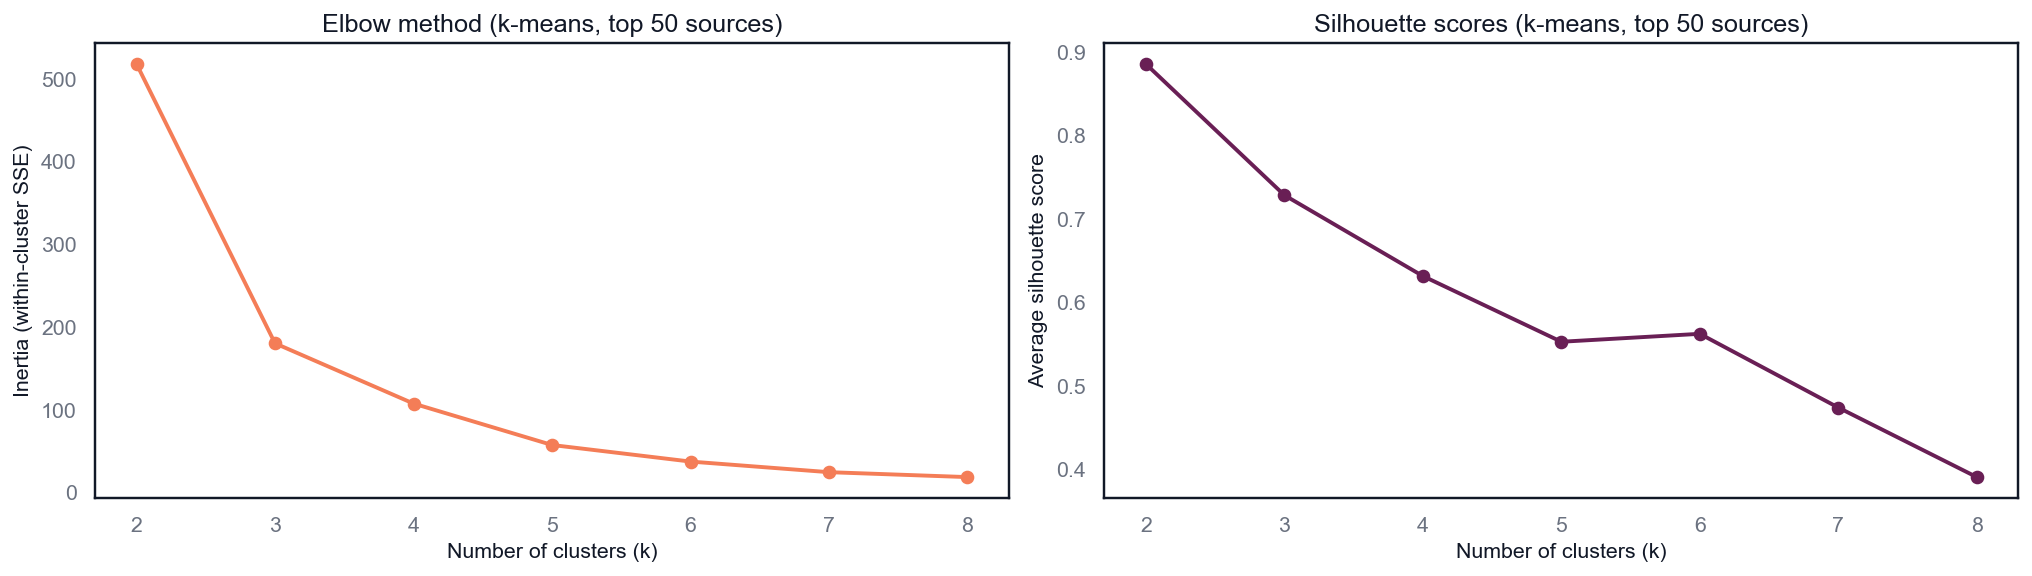

Top 50 sources cover 94.7% of territorial emissions (all years pooled).


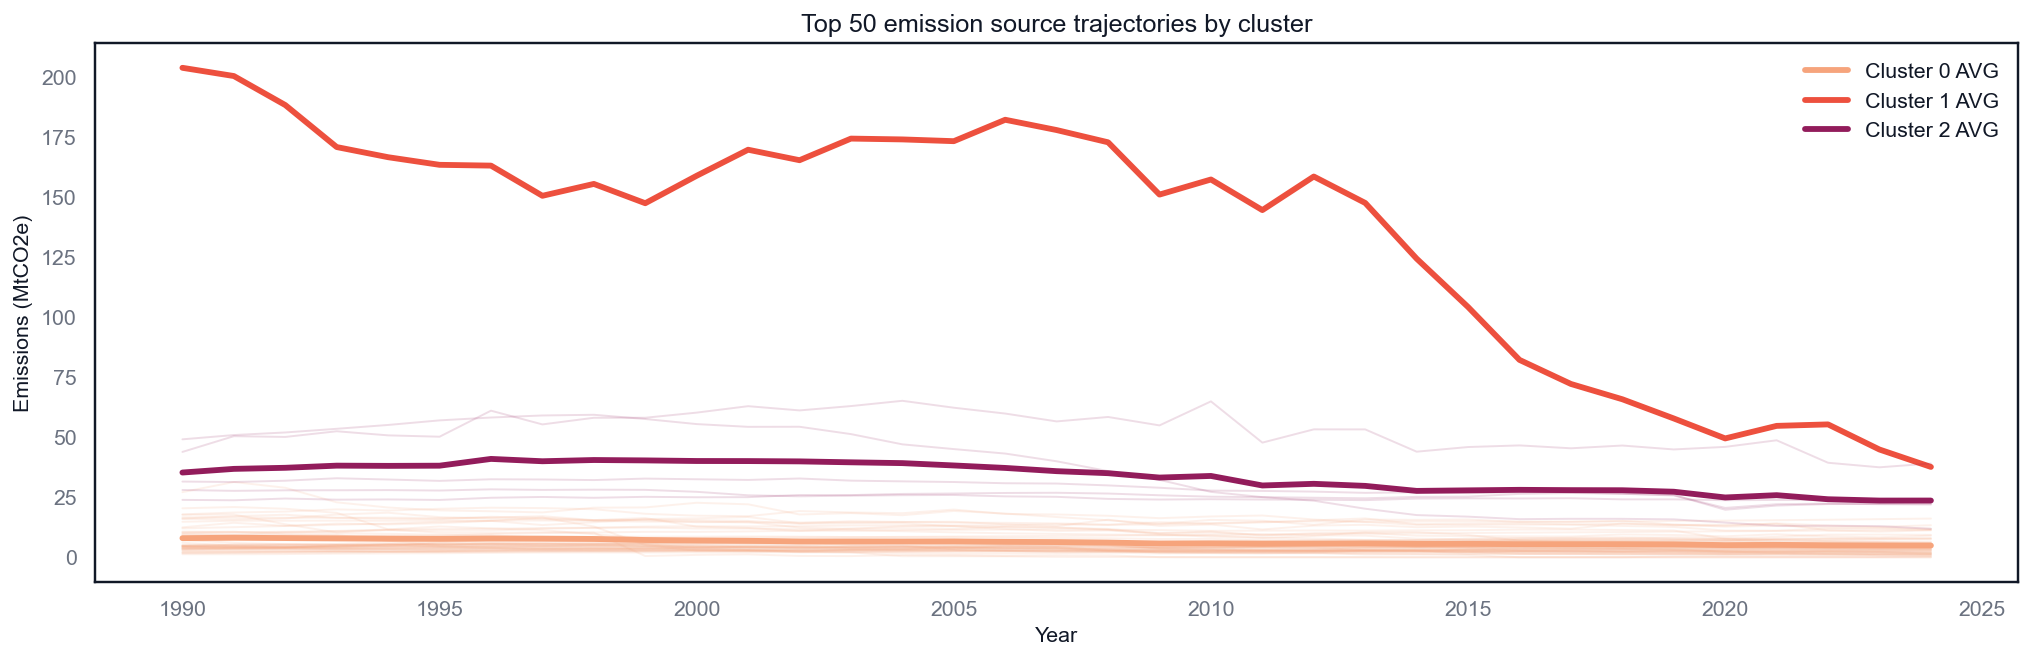

Cluster 0 (44 sources):
  - Other industrial combustion
  - Refineries - combustion
  - Domestic Water Heater
  - Miscellaneous industrial/commercial combustion
  - Carbon stock change in living biomass - Losses - Above-ground biomass - Conifer Mineral
  - Public sector combustion
  - Chemicals (combustion)
  - Iron and steel - combustion plant
  - Road transport - cars - motorway driving
  - Upstream Oil Production - fuel combustion
  - Carbon stock change in living biomass - Losses - Above-ground biomass - Broadleaf Mineral
  - Road transport - cars - cold start
  - Carbon stock change in living biomass - Losses - Below-ground biomass - Conifer Mineral
  - Carbon stock change in living biomass - Losses - Below-ground biomass - Broadleaf Mineral
  - Gas leakage
  - Road transport - HGV articulated - motorway driving
  - Net carbon stock change in soils - Mineral Soils - Land Use Change
  - Road transport - LGVs - rural driving
  - Deep-mined coal
  - Road transport - LGVs - urban driv

,n_sources,avg_1990,avg_2024,avg_pct_change
0,44.0,7.97,4.89,-38.71
1,1.0,203.99,37.66,-81.54
2,5.0,35.32,23.64,-33.05


In [120]:
# Source time series (Year x Source)
SRC_COL = "Source"

src_year = (
    territorial
    .groupby(["Year", SRC_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

pivot_src = (
    src_year
    .pivot(index="Year", columns=SRC_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

# Select top N sources by cumulative emissions (noise reduction)
N = 50
top_sources = (
    territorial.groupby(SRC_COL)["Emissions (MtCO2e)"]
    .sum()
    .sort_values(ascending=False)
    .head(N)
    .index
)

pivot_src_top = pivot_src.loc[:, top_sources].copy()

# X: rows = sources, cols = years
X = pivot_src_top.T
print("Shape (top sources x years):", X.shape)

# Scale trajectories
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow + silhouette (k selection support)
inertias, silhouettes = [], []
k_range = range(2, 9)

for kk in k_range:
    km = KMeans(n_clusters=kk, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(FIG_W * 1.6, 4.0), dpi=DPI, constrained_layout=True)

axes[0].plot(list(k_range), inertias, marker="o", linewidth=2, markersize=6, color=PAL_10[2])
axes[0].set_title(f"Elbow method (k-means, top {N} sources)")
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Inertia (within-cluster SSE)")
axes[0].grid(False)

axes[1].plot(list(k_range), silhouettes, marker="o", linewidth=2, markersize=6, color=PAL_10[7])
axes[1].set_title(f"Silhouette scores (k-means, top {N} sources)")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Average silhouette score")
axes[1].grid(False)

plt.show()

# Fit k-means (reporting choice)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

# Map: source -> cluster
cluster_map = pd.Series(labels, index=X.index, name="cluster").astype(int)

# Coverage check (share of territorial emissions captured by top N)
share = (territorial[territorial[SRC_COL].isin(top_sources)]["Emissions (MtCO2e)"].sum()
         / territorial["Emissions (MtCO2e)"].sum())

print(f"Top {N} sources cover {share:.1%} of territorial emissions (all years pooled).")

# Plot clustered trajectories (consistent palette, distinct but not darkest)
PAL_K = [PAL_10[i] for i in [1, 3, 6, 8, 9]]  # supports up to k=5

fig, ax = plt.subplots(figsize=(FIG_W * 1.6, 4.6), dpi=DPI, constrained_layout=True)

for c in range(k):
    members = cluster_map[cluster_map == c].index.tolist()
    col = PAL_K[c]

    for m in members:
        ax.plot(pivot_src_top.index, pivot_src_top[m], color=col, alpha=0.15, linewidth=1)

    ax.plot(
        pivot_src_top.index,
        pivot_src_top[members].mean(axis=1),
        color=col,
        linewidth=3,
        label=f"Cluster {c} AVG"
    )

ax.set_title(f"Top {N} emission source trajectories by cluster")
ax.set_xlabel("Year")
ax.set_ylabel("Emissions (MtCO2e)")
ax.legend(frameon=False)
plt.show()

# Print cluster membership (sorted by total emissions across years)
for c in sorted(cluster_map.unique()):
    members = cluster_map[cluster_map == c].index.tolist()
    members_sorted = sorted(
        members,
        key=lambda x: pivot_src_top[x].sum(),
        reverse=True
    )

    print(f"Cluster {c} ({len(members_sorted)} sources):")
    for m in members_sorted:
        print(f"  - {m}")
    print()

# Cluster summary (levels and % change, average across sources in cluster)
summary = pd.DataFrame(index=range(k))
year0 = pivot_src_top.index.min()
yearT = pivot_src_top.index.max()

for c in range(k):
    members = cluster_map[cluster_map == c].index.tolist()
    s0 = pivot_src_top.loc[year0, members].mean()
    sT = pivot_src_top.loc[yearT, members].mean()

    summary.loc[c, "n_sources"] = len(members)
    summary.loc[c, f"avg_{year0}"] = s0
    summary.loc[c, f"avg_{yearT}"] = sT
    summary.loc[c, "avg_pct_change"] = ((sT - s0) / abs(s0) * 100) if s0 != 0 else float("nan")

print("Cluster summary (average levels and percent change)")
display(summary.round(2))

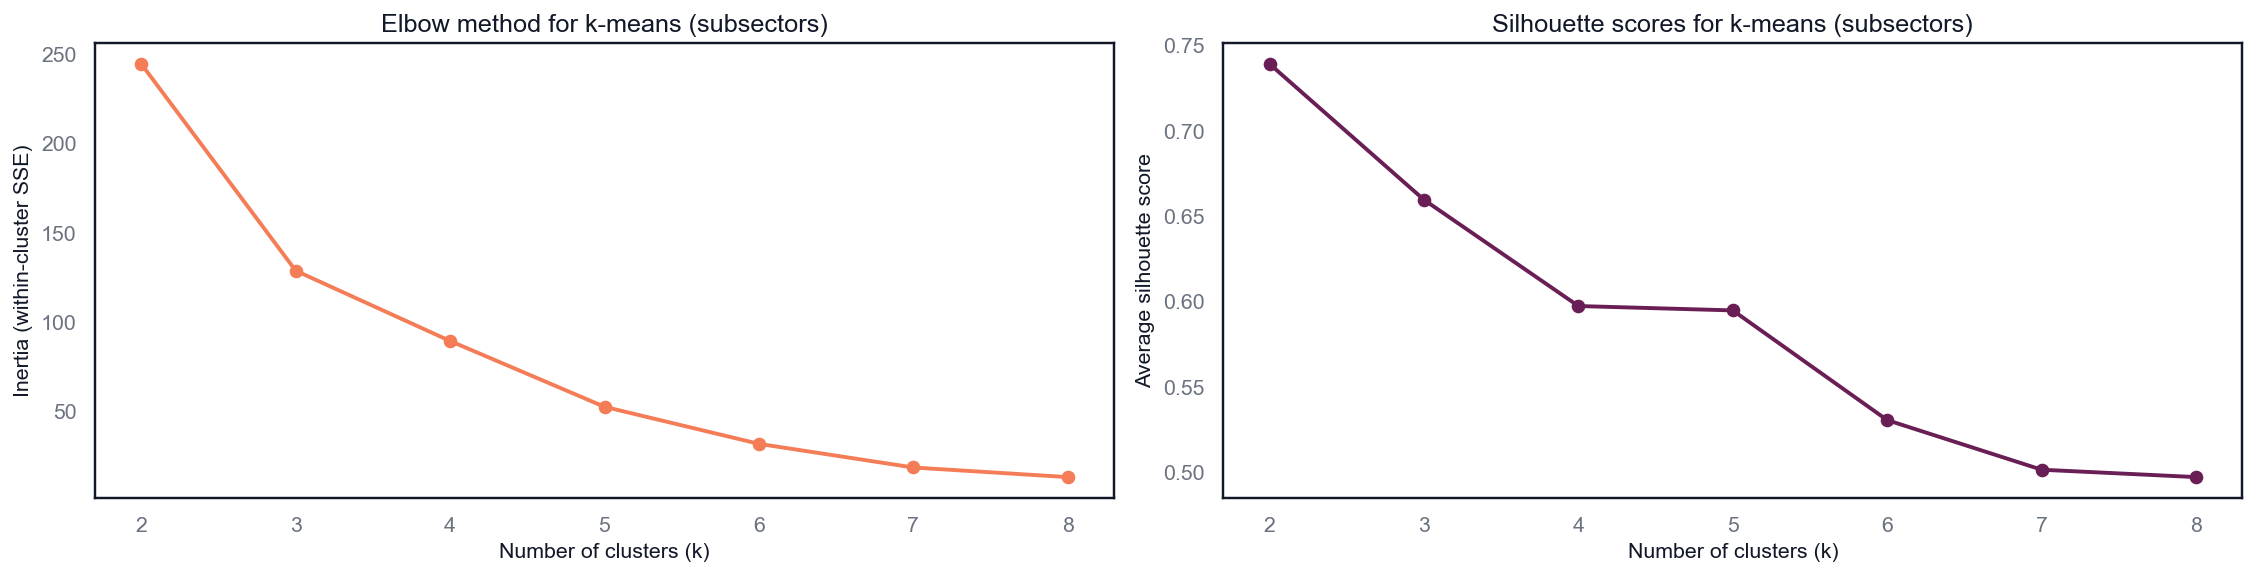

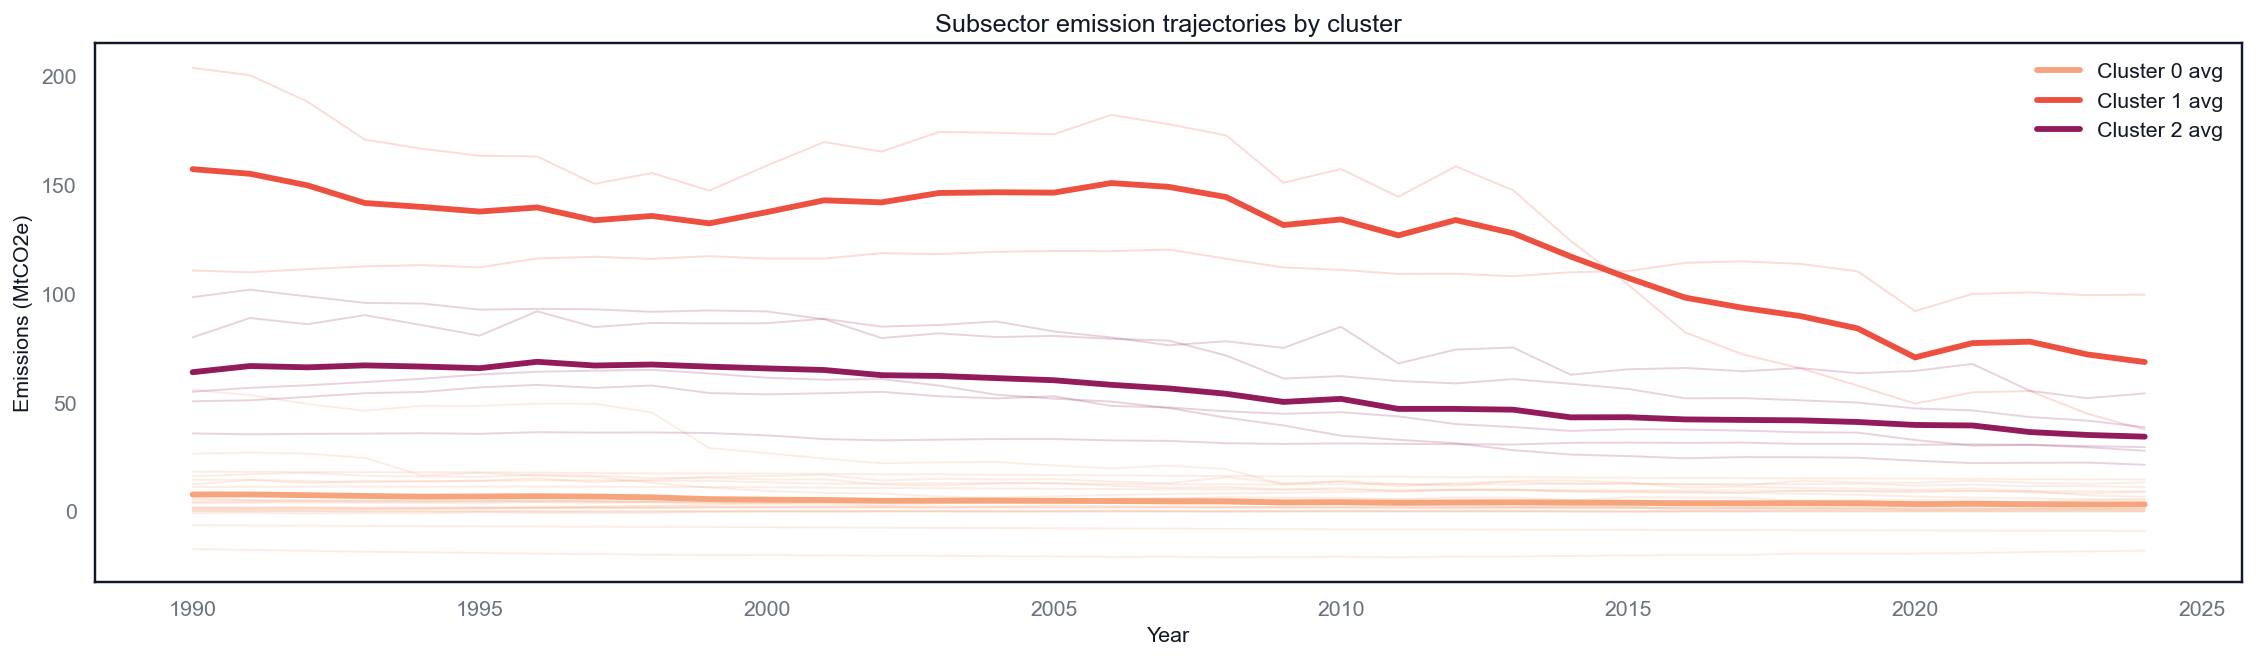


Cluster 0 (20 subsectors):
  - Agricultural combustion
  - Agricultural soils
  - Bioenergy crops
  - Civil aviation
  - Commercial buildings
  - Cropland mineral soils change
  - Forestry
  - Grassland mineral soils change
  - Industrial processes
  - Other LULUCF
  - Other agriculture
  - Other buildings and product uses
  - Other domestic transport
  - Other industry
  - Peatland
  - Public sector buildings
  - Railways
  - Settlement
  - Solid fuel supply
  - Waterborne

Cluster 1 (2 subsectors):
  - Power stations
  - Road

Cluster 2 (5 subsectors):
  - Industrial fuel combustion
  - Livestock
  - Oil and gas supply
  - Residential buildings
  - Waste

Subsector cluster summary (average levels and percent change)


,n_subsectors,avg_1990,avg_2024,avg_pct_change
0,20.0,7.80,3.21,-58.85
1,2.0,157.39,68.69,-56.36
2,5.0,64.02,34.37,-46.31


In [105]:
# Subsector (or sector) time series
SUB_COL = "Territorial Emissions Statistics subsector"

sub_year = (
    territorial
    .groupby(["Year", SUB_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

pivot_sub = (
    sub_year
    .pivot(index="Year", columns=SUB_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

# Rows = subsectors, columns = years
X = pivot_sub.T

# Scale trajectories
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow + silhouette to guide k
inertias = []
silhouettes = []
k_range = range(2, 9)

for kk in k_range:
    km = KMeans(n_clusters=kk, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Side-by-side plots (consistent styling, no grid)
fig, axes = plt.subplots(1, 2, figsize=(FIG_W * 1.6, 4.0), dpi=DPI, constrained_layout=True)

axes[0].plot(list(k_range), inertias, marker="o", linewidth=2, markersize=6, color=PAL_10[2])
axes[0].set_title("Elbow method for k-means (subsectors)")
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Inertia (within-cluster SSE)")
axes[0].grid(False)

axes[1].plot(list(k_range), silhouettes, marker="o", linewidth=2, markersize=6, color=PAL_10[7])
axes[1].set_title("Silhouette scores for k-means (subsectors)")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Average silhouette score")
axes[1].grid(False)

plt.show()

# Distinct (not darkest) colors from the established rocket_r palette
PAL_K = [PAL_10[i] for i in [1, 3, 6, 8, 9]]  # supports up to k=5

fig, ax = plt.subplots(figsize=(FIG_W * 1.6, 4.6), dpi=DPI, constrained_layout=True)

for c in range(k):
    members = cluster_map[cluster_map == c].index.tolist()
    col = PAL_K[c]

    # Individual trajectories (faint)
    for m in members:
        ax.plot(pivot_sub.index, pivot_sub[m], color=col, alpha=0.20, linewidth=1)

    # Cluster average (bold)
    ax.plot(
        pivot_sub.index,
        pivot_sub[members].mean(axis=1),
        color=col,
        linewidth=3,
        label=f"Cluster {c} avg"
    )

ax.set_title("Subsector emission trajectories by cluster")
ax.set_xlabel("Year")
ax.set_ylabel("Emissions (MtCO2e)")
ax.legend(frameon=False)
plt.show()

# Run k-means (choose k after inspecting the plots)
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = km.fit_predict(X_scaled)

# Assign clusters
cluster_map = pd.Series(labels, index=X.index, name="cluster").astype(int)

for c in range(k):
    members = cluster_map[cluster_map == c].index.tolist()
    print(f"\nCluster {c} ({len(members)} subsectors):")
    for m in members:
        print(f"  - {m}")

# Cluster summary for subsectors (levels and % change, average across subsectors in cluster)

summary_sub = pd.DataFrame(index=range(k))

year0 = pivot_sub.index.min()
yearT = pivot_sub.index.max()

for c in range(k):
    members = cluster_map[cluster_map == c].index.tolist()
    
    s0 = pivot_sub.loc[year0, members].mean()
    sT = pivot_sub.loc[yearT, members].mean()
    
    summary_sub.loc[c, "n_subsectors"] = len(members)
    summary_sub.loc[c, f"avg_{year0}"] = s0
    summary_sub.loc[c, f"avg_{yearT}"] = sT
    summary_sub.loc[c, "avg_pct_change"] = (
        (sT - s0) / abs(s0) * 100
    ) if s0 != 0 else float("nan")

print("\nSubsector cluster summary (average levels and percent change)")
display(summary_sub.round(2))

### Cluster analysis

To identify structurally distinct transition pathways, we apply k-means clustering to emission trajectories over the period 1990 to 2024. Two levels of aggregation are considered. First, clustering is performed at the subsector level to provide a clear and policy-relevant macro view of the transition. Second, clustering is conducted at the emission source level to capture the more granular drivers underlying the aggregate patterns.

For subsectors, each unit is represented by its full 35-year emission trajectory and standardised prior to clustering to ensure that grouping reflects similarities in trajectory shape rather than emission magnitude. The results indicate three clearly differentiated pathways. One cluster contains the two dominant emitters, Power stations and Road, characterised by high initial levels and substantial long-run decline, particularly following the mid-2010s. A second cluster groups mid-sized emitters, including Industrial fuel combustion, Livestock, Oil and gas supply, Residential buildings and Waste, which display a more gradual and persistent reduction pattern. The remaining subsectors form a third cluster of smaller emitters that collectively exhibit broad-based decline from relatively low initial levels.

At the source level, clustering is restricted to the top 50 sources ranked by cumulative emissions, which together account for 94.7 percent of territorial emissions across all years. This restriction reduces noise from negligible series and ensures that clustering reflects material emission drivers. As with subsectors, trajectories are standardised before applying k-means. The resulting source clusters mirror the high-level structure observed at the subsector level but provide greater detail, separating specific transport categories, heating-related sources and industrial processes into distinct transition groups. This confirms that the aggregate patterns are driven by identifiable underlying mechanisms rather than purely statistical artefacts of aggregation.

From a policy perspective, the cluster containing Power stations aligns with the most visible success of UK climate policy, notably the coal phase-out and electricity sector reform. The inclusion of Road transport in the same cluster highlights the central role of electrification and fuel efficiency standards in recent reductions. In contrast, the cluster containing Livestock, Industrial combustion and Residential buildings represents activities where decarbonisation depends on process-level innovation, behavioural change and infrastructure rollout rather than straightforward fuel substitution. Their comparatively slower decline suggests that these areas pose the main structural challenge for meeting future Carbon Budgets. The remaining cluster of smaller subsectors demonstrates that decarbonisation is not confined to a few headline sectors but reflects broader structural change across the economy.

Together, the clustering results provide a coherent classification of emission pathways, linking statistical patterns to economically meaningful drivers and policy-relevant transition dynamics.

---
# Question 3
## Policy Interpretation and Critical Analysis
1. Using the column Included in UK territorial total, compare emission trends with and
without international aviation and shipping. Discuss how this distinction affects progress as-
sessment against UK Carbon Budgets.

2. UsingtheIncluded in UK Paris Agreement total indicator,identifywhichemissionsources
arecoveredundertheUK’sParisAgreementreporting. Explaintheimplicationsofthiscoverage
for interpreting national emission reduction performance.

3. Based on your data-driven findings, critically assess whether historical emission trends suggest
that the UK is structurally aligned with its long-term climate targets. Support your answer with
quantitative evidence from your analysis.
---

### Territorial total vs. territorial + international aviation and shipping

The column *Included in UK territorial total* defines the official UK territorial boundary used for Carbon Budget accounting.  
To quantify the difference, I compute two annual series:

- **Territorial total**: sum of emissions where *Included in UK territorial total = Yes*  
- **Territorial + int. aviation and shipping**: sum of emissions across all rows (includes those marked No)

,Start (MtCO2e),End (MtCO2e),Abs change,Pct change (%)
Territorial total,790.82,373.40,-417.42,-52.78
Territorial + aviation & shipping,812.84,414.64,-398.20,-48.99


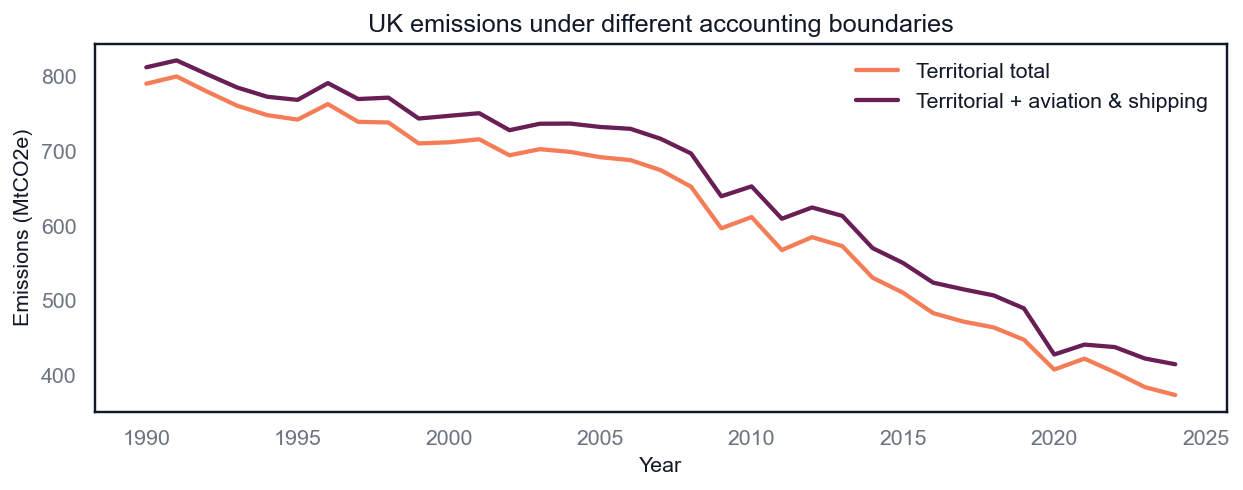

,Excluded (aviation & shipping etc.)
Year,
1990,22.014057
1991,21.520560
1992,23.327447
1993,24.444659
1994,24.649550
1995,26.441232
1996,28.144601
1997,30.589072
1998,33.281505


In [122]:
# Territorial total vs. territorial + international aviation & shipping

# Make sure theme/palette from earlier cells are active
if "set_clean_theme" in globals():
    set_clean_theme()

df = uk_by_source.copy()

value_col = "Emissions (MtCO2e)"

terr_total = (
    df[df["Included in UK territorial total"] == "Yes"]
    .groupby("Year")[value_col]
    .sum()
    .sort_index()
)

terr_plus_avi_ship = (
    df.groupby("Year")[value_col]
    .sum()
    .sort_index()
)

trend_q31 = pd.DataFrame({
    "Territorial total": terr_total,
    "Territorial + aviation & shipping": terr_plus_avi_ship
})

# Summary stats
y0, yT = trend_q31.index.min(), trend_q31.index.max()
summary_q31 = pd.DataFrame({
    "Start (MtCO2e)": trend_q31.loc[y0],
    "End (MtCO2e)": trend_q31.loc[yT],
    "Abs change": trend_q31.loc[yT] - trend_q31.loc[y0],
    "Pct change (%)": (trend_q31.loc[yT] / trend_q31.loc[y0] - 1) * 100
}).round(2)

display(summary_q31)

# Plot with consistent palette
c0 = PAL_10[2] if "PAL_10" in globals() else None
c1 = PAL_10[7] if "PAL_10" in globals() else None

plt.figure(figsize=(FIG_W, 3.6), dpi=DPI)

plt.plot(
    trend_q31.index,
    trend_q31["Territorial total"],
    label="Territorial total",
    color=c0,
    linewidth=2.2
)

plt.plot(
    trend_q31.index,
    trend_q31["Territorial + aviation & shipping"],
    label="Territorial + aviation & shipping",
    color=c1,
    linewidth=2.2
)

plt.title("UK emissions under different accounting boundaries")
plt.xlabel("Year")
plt.ylabel("Emissions (MtCO2e)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# Gap table (what is excluded from the territorial boundary)
gap_q31 = (terr_plus_avi_ship - terr_total).rename("Excluded (aviation & shipping etc.)")
display(gap_q31.to_frame().head(10))